In [1]:
from rubix.config.config import UserConfig
confdict = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    }}
conf = UserConfig(confdict)
conf["pipeline/name"]

'calc_ifu'

In [2]:
conf

UserConfig({
    "pipeline": {
        "name": "calc_ifu"
    },
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": null,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    }
})

In [3]:
from rubix.utils import get_config
get_config(confdict)

UserConfig({
    "pipeline": {
        "name": "calc_ifu"
    },
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": null,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    }
})

2024-06-09 21:03:29,040 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <  
/_/|_|\____/____/___/_/|_|  
                            

2024-06-09 21:03:29,041 - rubix - INFO - Rubix version: 0.0.1.post55+g93a544d
/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:21: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2024-06-09 21:03:29,462 - rubix - INFO - Getting rubix data...
2024-06-09 21:03:29,463 - rubix - WARNING - Rubix galaxy file already exists, skipping conversion
2024-06-09 21:03:31,431 - rubix - WARNING - The Subset value is set in config. Using only subset of size 10
2024-06-09 21:03:31,433 - rubix - INFO - Data loaded with 10 particles.
2024-06-09 21:03:31,433 - rubix - INFO - Setting up the pipeline...
/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:21: 

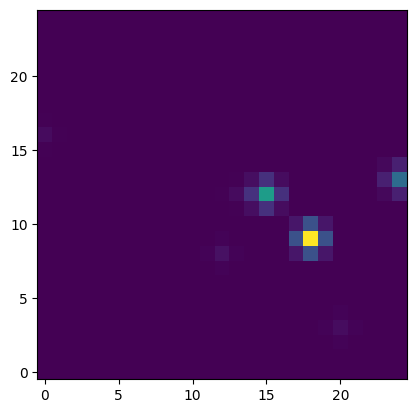

In [1]:
#NBVAL_SKIP
import matplotlib.pyplot as plt
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "INFO",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "output_path": os.path.join(os.getcwd(), "output"),
        "save_name": "tng_14",
        "subset": {
            "use_subset": True,
            "subset_size": 10,
        },
        "simulation": {
            "name": "IllustrisAPI",
            "args": {
                "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
                "particle_type": ["stars"],
                "simulation": "TNG50-1",
                "snapshot": 99,
                "galaxy_id": 14,
                "reuse": True,
                    }
                        },
        
    },
    "telescope":
        {"name": "MUSE",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5}},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

pipe = RubixPipeline(config)

data= pipe.run()

datacube = data["datacube"]
img = datacube.sum(axis=2)
plt.imshow(img, origin="lower")

In [ ]:
#NBVAL_SKIP
wave = pipe.telescope.wave_seq
spectra = data["spectra"] # Spectra of all stars
print(spectra.shape)

plt.plot(wave, spectra[0,3]) 


Some of the spectra may be zero, this happens if the metallicity or age values are outside the range of the SSP model. This is currently the expected behavior

In [ ]:
#NBVAL_SKIP
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 3721))
    
    return ifu_cube

spectra = data["spectra"]
assignments = data["pixel_assignment"]

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

In [ ]:
#NBVAL_SKIP
wavelengths = pipe.telescope.wave_seq

# get the indices of the visible wavelengths of 4000-8000 Angstroms

visible_indices = jnp.where((wavelengths >= 4000) & (wavelengths <= 8000))



In [ ]:
#NBVAL_SKIP
wavelengths

In [ ]:
#NBVAL_SKIP
spectra[0,7]

In [ ]:
#NBVAL_SKIP
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths[visible_indices], spec[visible_indices])
plt.yscale("log")

In [ ]:
#NBVAL_SKIP
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = final_ifu_cube[:, :, visible_indices[0]]
visible_spectra.shape

In [ ]:
#NBVAL_SKIP
# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
plt.imshow(image, origin="lower", cmap="inferno")
plt.colorbar()